# Text Preprocessing: HTML Tags & Length Normalization

This notebook addresses two key preprocessing steps for the reviews dataset:
1. HTML tag cleaning
2. Text length normalization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
import src.data.utils as utils

In [2]:
# Load the dataset
df = pd.read_csv('../dataset/processed/Reviews_removed_columns.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (20038, 4)


,Id,Score,Summary,Text
0,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,5,Great taffy,Great taffy at a great price. There was a wid...


## 1. HTML Tag Cleaning

Many reviews contain HTML tags which can interfere with text analysis. We'll identify, analyze, and remove these tags.

In [3]:
# Identify reviews with HTML tags
df['Has_HTML_Tags'] = df['Text'].apply(utils.contains_html_tags)

# Count and percentage
html_count = df['Has_HTML_Tags'].sum()
html_percentage = html_count / len(df) * 100

print(f"Reviews containing HTML tags: {html_count} ({html_percentage:.2f}%)")

Reviews containing HTML tags: 5185 (25.88%)


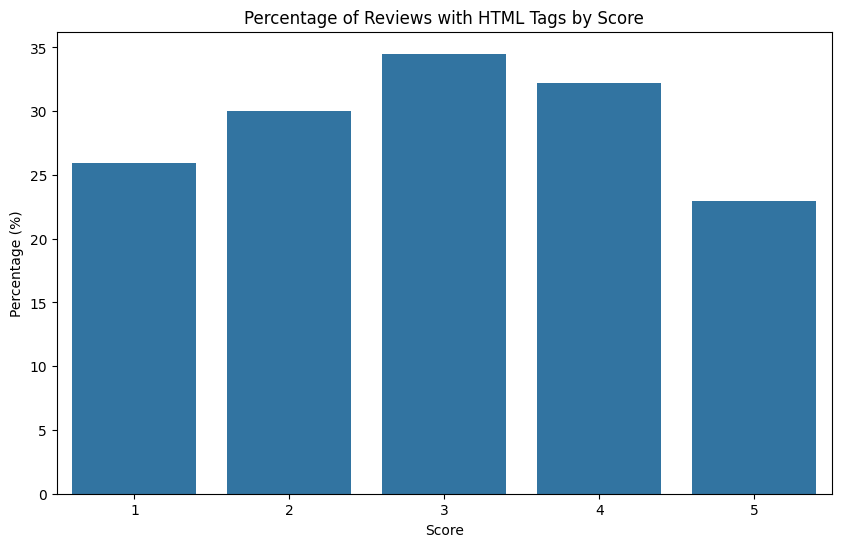

In [4]:
# Distribution of HTML tags across score categories
html_by_score = df.groupby('Score')['Has_HTML_Tags'].mean() * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=html_by_score.index, y=html_by_score.values)
plt.title('Percentage of Reviews with HTML Tags by Score')
plt.xlabel('Score')
plt.ylabel('Percentage (%)')
plt.show()

In [5]:
# Examine some examples of HTML tags
html_examples = df[df['Has_HTML_Tags']].head(5)

for i, row in html_examples.iterrows():
    print(f"Review ID: {row['Id']}")
    print(f"Original text:\n{row['Text'][:200]}...\n")

Review ID: 11
Original text:
I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on...

Review ID: 19
Original text:
Twizzlers, Strawberry my childhood favorite candy, made in Lancaster Pennsylvania by Y & S Candies, Inc. one of the oldest confectionery Firms in the United States, now a Subsidiary of the Hershey Com...

Review ID: 22
Original text:
I bought these for my husband who is currently overseas. He loves these, and apparently his staff likes them also.<br />There are generous amounts of Twizzlers in each 16-ounce bag, and this was well ...

Review ID: 25
Original text:
I have lived out of the US for over 7 yrs now, and I so miss my Twizzlers!!  When I go back to visit or someone visits me, I always stock up.  All I can say is YUM!<br />Sell these in Mexico and you w...

Review ID: 26
Original text:
Product received is as advertised.<

In [6]:
# Clean HTML tags and compare lengths
df['Text_Clean'] = df['Text'].apply(utils.clean_html)

# Calculate lengths before and after cleaning
df['Text_Length_Original'] = df['Text'].apply(len)
df['Text_Length_Clean'] = df['Text_Clean'].apply(len)
df['Length_Difference'] = df['Text_Length_Original'] - df['Text_Length_Clean']

In [7]:
# Show examples of cleaned text
for i, row in df[df['Has_HTML_Tags']].head().iterrows():
    print(f"Review ID: {row['Id']}")
    print(f"Original length: {len(row['Text'])}")
    print(f"Cleaned length: {len(row['Text_Clean'])}")
    print(f"Original:\n{row['Text'][:150]}...\n")
    print(f"Cleaned:\n{row['Text_Clean'][:150]}...\n")
    print("-" * 80)

# Display statistics for records with HTML tags
html_stats = df[df['Has_HTML_Tags']][['Text_Length_Original', 'Text_Length_Clean', 'Length_Difference']].describe()
html_stats

Review ID: 11
Original length: 779
Cleaned length: 743
Original:
I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind...

Cleaned:
I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind...

--------------------------------------------------------------------------------
Review ID: 19
Original length: 746
Cleaned length: 735
Original:
Twizzlers, Strawberry my childhood favorite candy, made in Lancaster Pennsylvania by Y & S Candies, Inc. one of the oldest confectionery Firms in the ...

Cleaned:
Twizzlers, Strawberry my childhood favorite candy, made in Lancaster Pennsylvania by Y & S Candies, Inc. one of the oldest confectionery Firms in the ...

--------------------------------------------------------------------------------
Review ID: 22
Original length: 323
Cleaned length: 260
Original:
I bou

,Text_Length_Original,Text_Length_Clean,Length_Difference
count,5185.000000,5185.000000,5185.000000
mean,769.604050,736.751013,32.853038
std,636.841841,613.500959,42.181134
min,65.000000,59.000000,5.000000
25%,368.000000,350.000000,11.000000
50%,619.000000,591.000000,22.000000
75%,966.000000,927.000000,38.000000
max,10327.000000,9928.000000,715.000000


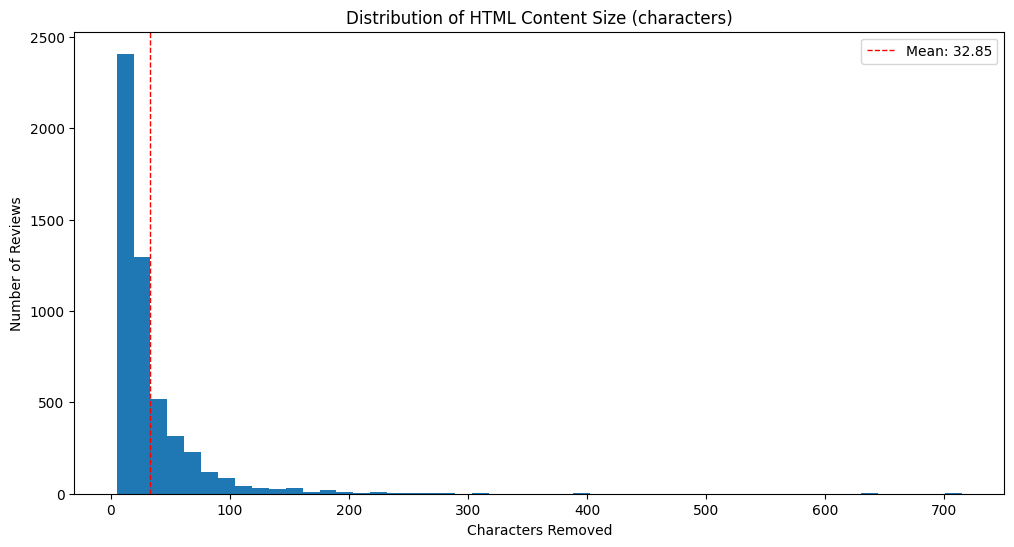

In [8]:
# Visualize the distribution of HTML content size
html_df = df[df['Has_HTML_Tags']]
plt.figure(figsize=(12, 6))
plt.hist(html_df['Length_Difference'], bins=50)
plt.title('Distribution of HTML Content Size (characters)')
plt.xlabel('Characters Removed')
plt.ylabel('Number of Reviews')
plt.axvline(html_df['Length_Difference'].mean(), color='r', linestyle='dashed', 
            linewidth=1, label=f'Mean: {html_df["Length_Difference"].mean():.2f}')
plt.legend()
plt.show()

## 2. Text Length Normalization

The dataset has extreme outliers in text length. We'll implement various normalization strategies to address this.

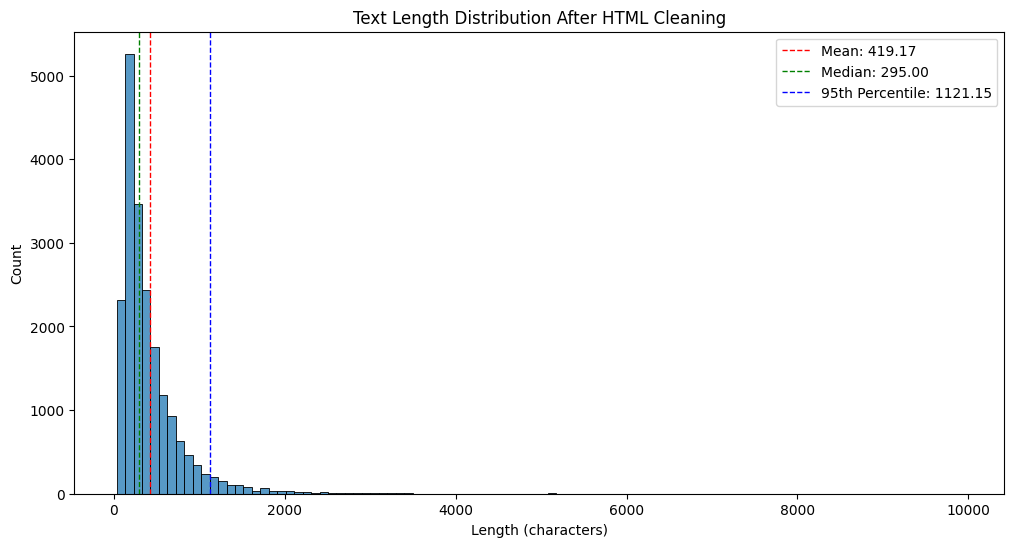

In [9]:
# Analyze length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['Text_Length_Clean'], bins=100)
plt.title('Text Length Distribution After HTML Cleaning')
plt.xlabel('Length (characters)')
plt.ylabel('Count')

# Add vertical lines for key statistics
mean_len = df['Text_Length_Clean'].mean()
median_len = df['Text_Length_Clean'].median()
p95_len = df['Text_Length_Clean'].quantile(0.95)
max_len = df['Text_Length_Clean'].max()

plt.axvline(mean_len, color='r', linestyle='dashed', linewidth=1, 
            label=f'Mean: {mean_len:.2f}')
plt.axvline(median_len, color='g', linestyle='dashed', linewidth=1, 
            label=f'Median: {median_len:.2f}')
plt.axvline(p95_len, color='b', linestyle='dashed', linewidth=1, 
            label=f'95th Percentile: {p95_len:.2f}')
plt.legend()
plt.show()

In [10]:
# Identify extreme outliers
q75 = df['Text_Length_Clean'].quantile(0.75)
q25 = df['Text_Length_Clean'].quantile(0.25)
iqr = q75 - q25

upper_limit = q75 + 1.5 * iqr
extreme_upper_limit = q75 + 3 * iqr

outliers = df[df['Text_Length_Clean'] > upper_limit]
extreme_outliers = df[df['Text_Length_Clean'] > extreme_upper_limit]

print(f"Number of outliers (> Q3 + 1.5*IQR): {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
print(f"Number of extreme outliers (> Q3 + 3*IQR): {len(extreme_outliers)} ({len(extreme_outliers)/len(df)*100:.2f}%)")
print(f"Upper limit (Q3 + 1.5*IQR): {upper_limit:.2f} characters")
print(f"Extreme upper limit (Q3 + 3*IQR): {extreme_upper_limit:.2f} characters")

Number of outliers (> Q3 + 1.5*IQR): 1255 (6.26%)
Number of extreme outliers (> Q3 + 3*IQR): 439 (2.19%)
Upper limit (Q3 + 1.5*IQR): 1019.50 characters
Extreme upper limit (Q3 + 3*IQR): 1525.00 characters


### 2.1 Normalization Strategy 1: Truncation

Cap the maximum length of reviews based on percentiles.

In [11]:
# Define truncation thresholds
p90_len = df['Text_Length_Clean'].quantile(0.9)
p95_len = df['Text_Length_Clean'].quantile(0.95)
p99_len = df['Text_Length_Clean'].quantile(0.99)

print(f"90th percentile length: {p90_len:.2f} characters")
print(f"95th percentile length: {p95_len:.2f} characters")
print(f"99th percentile length: {p99_len:.2f} characters")

90th percentile length: 834.30 characters
95th percentile length: 1121.15 characters
99th percentile length: 2027.15 characters


In [12]:
# Define truncation functions
def truncate_text(text, max_length):
    if len(text) <= max_length:
        return text
    return text[:max_length]

# Apply different truncation levels
df['Text_Trunc_P90'] = df['Text_Clean'].apply(lambda x: truncate_text(x, int(p90_len)))
df['Text_Trunc_P95'] = df['Text_Clean'].apply(lambda x: truncate_text(x, int(p95_len)))
df['Text_Trunc_P99'] = df['Text_Clean'].apply(lambda x: truncate_text(x, int(p99_len)))

# Calculate percentage of reviews affected by each truncation
affected_p90 = (df['Text_Length_Clean'] > p90_len).sum() / len(df) * 100
affected_p95 = (df['Text_Length_Clean'] > p95_len).sum() / len(df) * 100
affected_p99 = (df['Text_Length_Clean'] > p99_len).sum() / len(df) * 100

print(f"Reviews affected by P90 truncation: {affected_p90:.2f}%")
print(f"Reviews affected by P95 truncation: {affected_p95:.2f}%")
print(f"Reviews affected by P99 truncation: {affected_p99:.2f}%")

Reviews affected by P90 truncation: 10.00%
Reviews affected by P95 truncation: 5.00%
Reviews affected by P99 truncation: 1.00%


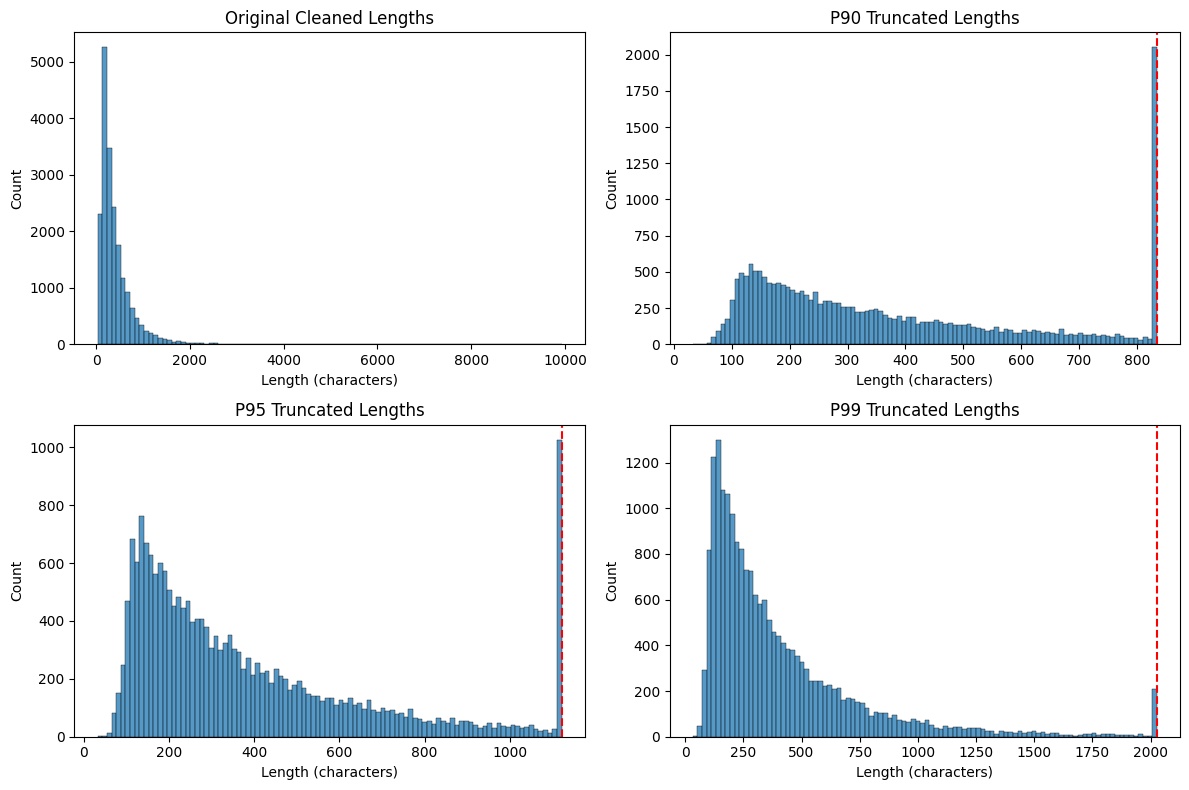

In [13]:
# Compare text length distributions before and after truncation
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(df['Text_Length_Clean'], bins=100)
plt.title('Original Cleaned Lengths')
plt.xlabel('Length (characters)')

plt.subplot(2, 2, 2)
sns.histplot(df['Text_Trunc_P90'].apply(len), bins=100)
plt.axvline(p90_len, color='r', linestyle='dashed')
plt.title('P90 Truncated Lengths')
plt.xlabel('Length (characters)')

plt.subplot(2, 2, 3)
sns.histplot(df['Text_Trunc_P95'].apply(len), bins=100)
plt.axvline(p95_len, color='r', linestyle='dashed')
plt.title('P95 Truncated Lengths')
plt.xlabel('Length (characters)')

plt.subplot(2, 2, 4)
sns.histplot(df['Text_Trunc_P99'].apply(len), bins=100)
plt.axvline(p99_len, color='r', linestyle='dashed')
plt.title('P99 Truncated Lengths')
plt.xlabel('Length (characters)')

plt.tight_layout()
plt.show()

### 2.2 Normalization Strategy 2: Statistical Normalization

Apply statistical normalization to text length as a feature.

In [14]:
# Calculate z-score normalization (standard scaling)
df['Length_Z_Score'] = (df['Text_Length_Clean'] - df['Text_Length_Clean'].mean()) / df['Text_Length_Clean'].std()

# Calculate min-max normalization
min_len = df['Text_Length_Clean'].min()
max_len = df['Text_Length_Clean'].max()
df['Length_MinMax'] = (df['Text_Length_Clean'] - min_len) / (max_len - min_len)

# Calculate robust scaling (based on IQR)
median_len = df['Text_Length_Clean'].median()
df['Length_Robust'] = (df['Text_Length_Clean'] - median_len) / iqr

# Calculate log transformation
df['Length_Log'] = np.log1p(df['Text_Length_Clean'])  # log1p to handle zeros

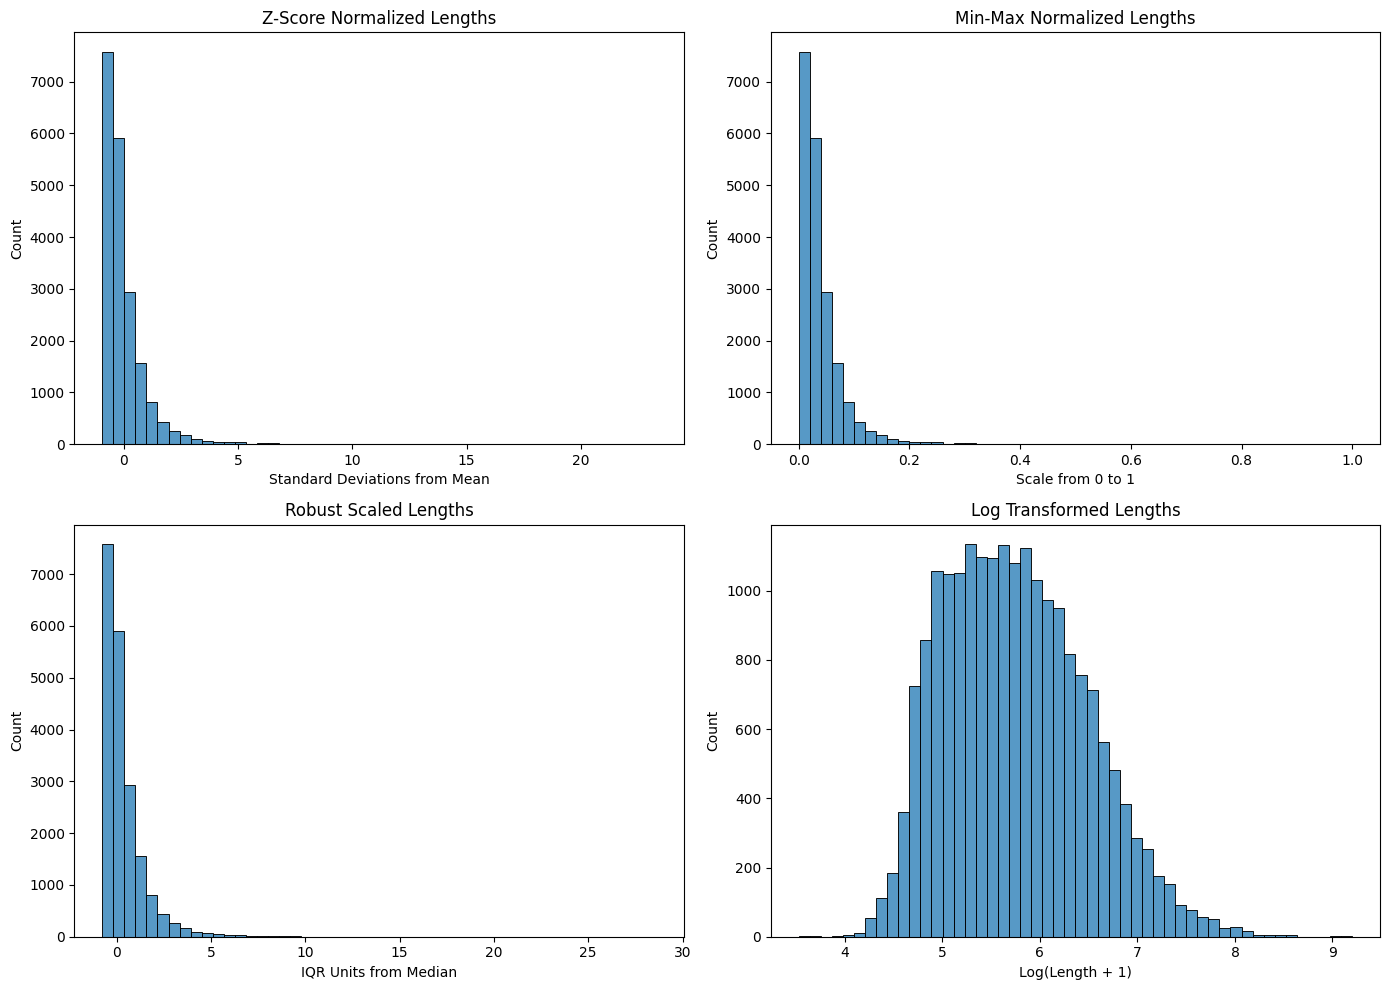

In [15]:
# Compare distributions of normalized values
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(df['Length_Z_Score'], bins=50)
plt.title('Z-Score Normalized Lengths')
plt.xlabel('Standard Deviations from Mean')

plt.subplot(2, 2, 2)
sns.histplot(df['Length_MinMax'], bins=50)
plt.title('Min-Max Normalized Lengths')
plt.xlabel('Scale from 0 to 1')

plt.subplot(2, 2, 3)
sns.histplot(df['Length_Robust'], bins=50)
plt.title('Robust Scaled Lengths')
plt.xlabel('IQR Units from Median')

plt.subplot(2, 2, 4)
sns.histplot(df['Length_Log'], bins=50)
plt.title('Log Transformed Lengths')
plt.xlabel('Log(Length + 1)')

plt.tight_layout()
plt.show()

In [16]:
# Check skewness before and after transformations
print(f"Original length skewness: {df['Text_Length_Clean'].skew():.4f}")
print(f"Z-score normalized skewness: {df['Length_Z_Score'].skew():.4f}")
print(f"Min-max normalized skewness: {df['Length_MinMax'].skew():.4f}")
print(f"Robust scaled skewness: {df['Length_Robust'].skew():.4f}")
print(f"Log transformed skewness: {df['Length_Log'].skew():.4f}")

Original length skewness: 4.5818
Z-score normalized skewness: 4.5818
Min-max normalized skewness: 4.5818
Robust scaled skewness: 4.5818
Log transformed skewness: 0.4471


### 2.3 Normalization Strategy 3: Length Binning

Convert text length into categorical bins for feature engineering.

In [17]:
# Create length bins
bins = [0, 100, 250, 500, 750, 1000, 1500, df['Text_Length_Clean'].max()]
labels = ['Very Short', 'Short', 'Medium-Short', 'Medium', 'Medium-Long', 'Long', 'Very Long']

df['Length_Category'] = pd.cut(df['Text_Length_Clean'], bins=bins, labels=labels)

# Display distribution of length categories
len_cat_counts = df['Length_Category'].value_counts().sort_index()
len_cat_percent = df['Length_Category'].value_counts(normalize=True).sort_index() * 100

len_cat_df = pd.DataFrame({
    'Count': len_cat_counts,
    'Percentage (%)': len_cat_percent
})

len_cat_df

,Count,Percentage (%)
Length_Category,,
Very Short,567,2.829624
Short,7834,39.095718
Medium-Short,6400,31.939315
Medium,2741,13.679010
Medium-Long,1175,5.863859
Long,865,4.316798
Very Long,456,2.275676


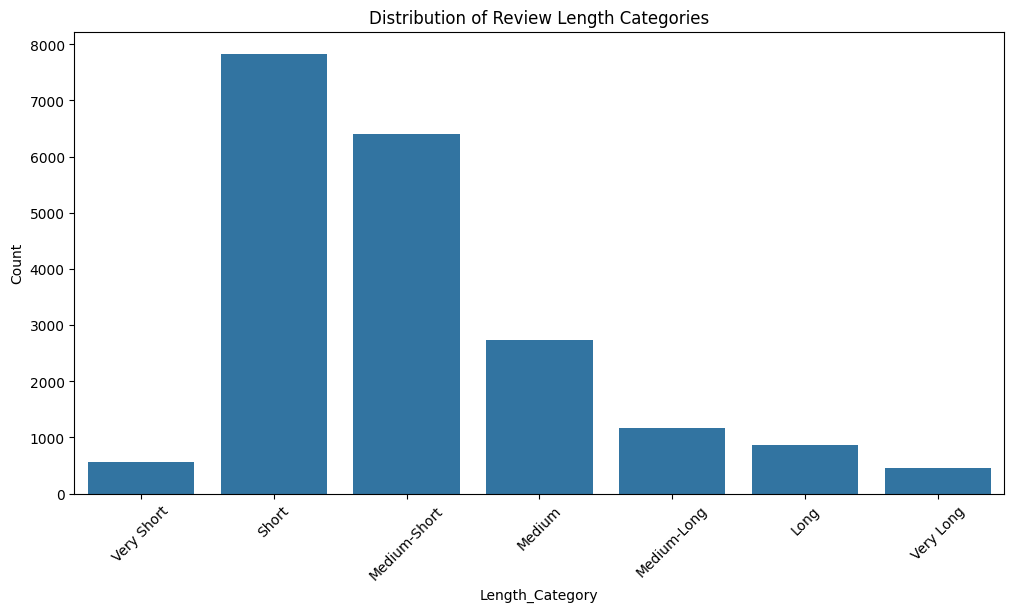

In [18]:
# Visualize length categories
plt.figure(figsize=(12, 6))
sns.countplot(x='Length_Category', data=df)
plt.title('Distribution of Review Length Categories')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

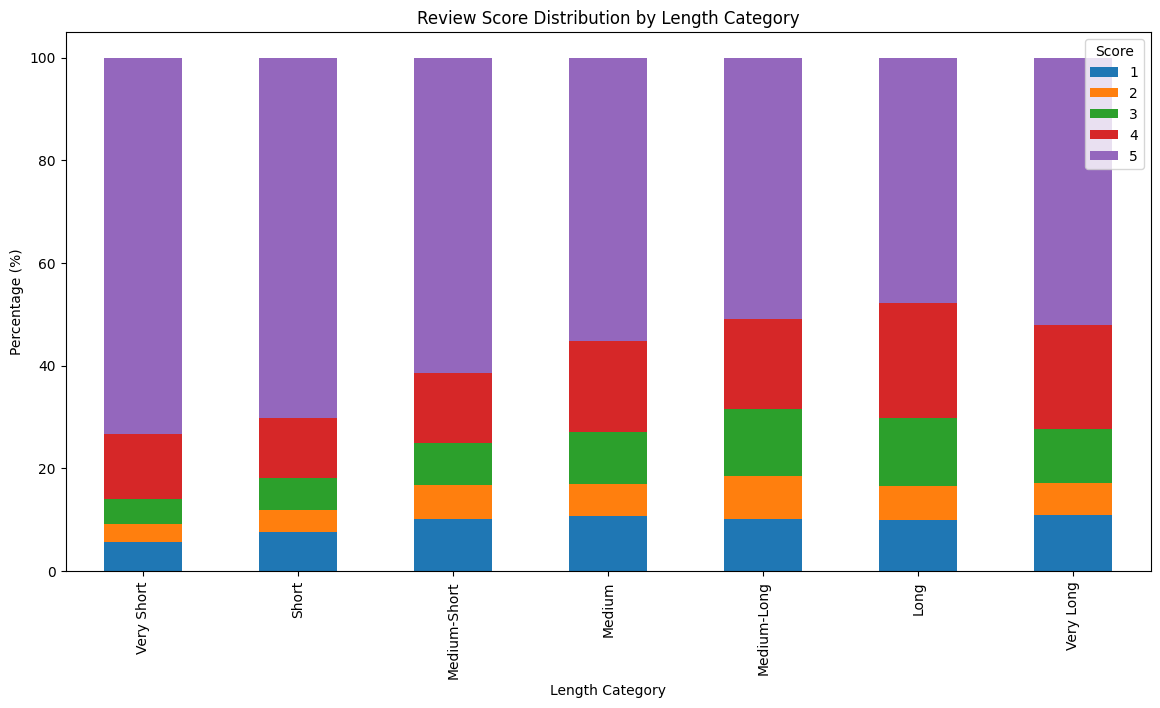

In [19]:
# Check relationship between length categories and score
length_score = pd.crosstab(df['Length_Category'], df['Score'], normalize='index') * 100
length_score.plot(kind='bar', figsize=(14, 7), stacked=True)
plt.title('Review Score Distribution by Length Category')
plt.xlabel('Length Category')
plt.ylabel('Percentage (%)')
plt.legend(title='Score')
plt.show()

## 3. Export Preprocessed Data

Save the cleaned and normalized data for downstream tasks.

In [20]:
# Prepare final dataset with selected columns
preprocessed_df = df[['Id', 'Score', 'Summary', 
                      'Text_Clean',  # HTML-cleaned text
                      'Text_Trunc_P95',  # P95 truncated text 
                      'Length_Category',  # Length category
                      'Length_Log']]  # Log-transformed length

# Rename columns for clarity
preprocessed_df = preprocessed_df.rename(columns={
    'Text_Clean': 'Text_HTML_Clean',
    'Text_Trunc_P95': 'Text_Normalized',
    'Length_Log': 'Length_Feature'
})

# Save to CSV
preprocessed_df.to_csv('../dataset/processed/Reviews_preprocessed.csv', index=False)
print(f"Saved preprocessed data with {len(preprocessed_df)} records.")

Saved preprocessed data with 20038 records.


## 4. Summary of Actions

### HTML Tag Cleaning
- Approximately 26% of reviews contain HTML tags
- HTML content varies in length and complexity
- Cleaning HTML leads to more consistent, machine-readable text

### Length Normalization
- Text length is highly skewed with extreme outliers
- Various normalization strategies implemented:
  - Truncation at 90th, 95th, and 99th percentiles
  - Statistical normalization (Z-score, min-max, robust scaling, log transformation)
  - Categorical binning of lengths
- Log transformation most effectively reduces skewness
- Length category shows potential relationship with review scores